Try creating a fully convolutional net with adaptive average pooling for MNIST (note that you'll need fewer stride-2 layers). How does it compare to a network without such a pooling layer?

In [1]:
from fastai.vision.all import *

In [2]:
path = untar_data(URLs.MNIST)
path.ls()

(#2) [Path('/root/.fastai/data/mnist_png/training'),Path('/root/.fastai/data/mnist_png/testing')]

In [3]:
def get_dls(bs=64):
    return DataBlock(
        blocks = (ImageBlock(cls = PILImageBW), CategoryBlock),
        get_items=get_image_files,
        splitter=GrandparentSplitter('training', 'testing'),
        get_y=parent_label,
        batch_tfms=Normalize()
    ).dataloaders(path, bs=bs)
dls = get_dls()

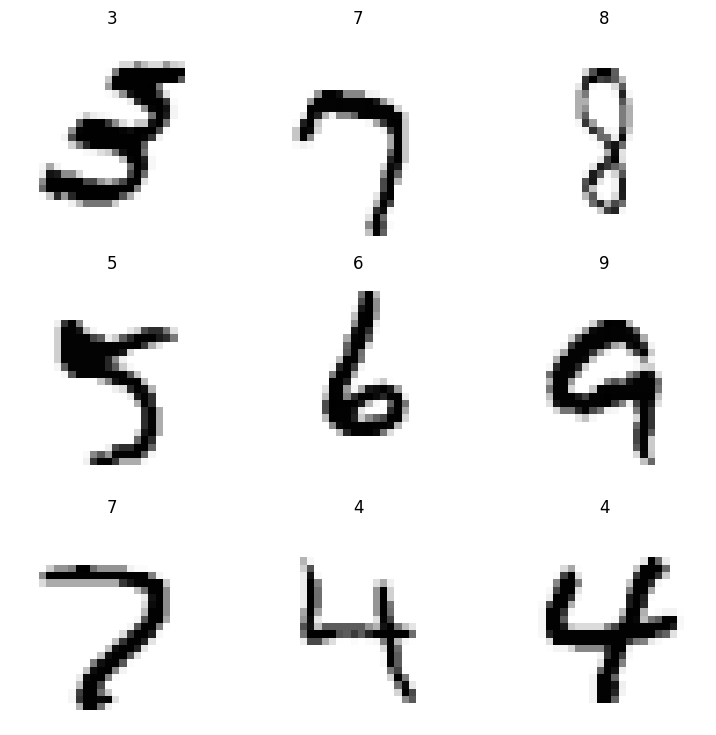

In [4]:
dls.show_batch()

In [5]:
def conv(ni, nf, ks=3, act=True, stride=2):
    layers = [nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2 )]
    layers.append(nn.BatchNorm2d(nf))
    if act:
        layers.append(nn.ReLU())

    return nn.Sequential(*layers)

In [6]:
def simple_cnn():
    return sequential(
        conv(1, 8, ks=5),           # 8 * 14 * 14
        conv(8, 16),                # 16 * 7 * 7
        conv(16, 32),               # 32 * 4 * 4
        conv(32, 64, act=True),     # 64 * 2 * 2
        #nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Linear(64, dls.c)
    )

In [7]:
from fastai.callback.hook import *
def fit(model, epochs = 1):
    learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(),
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit_one_cycle(epochs, 0.06)
    return learn

## Debugging the arch

In [9]:
learner = fit(simple_cnn(), 10)

/usr/local/lib/python3.10/dist-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x256 and 64x10)

In [38]:
x, y = dls.one_batch()
x = x.cpu()

In [20]:
model = simple_cnn().to(torch.device('cpu'))

In [40]:
next(model.parameters()).is_cuda, next(model.parameters()).is_cpu,  x.is_cpu

(False, True, True)

In [41]:
intrim_data = x
for i, layer in enumerate(model.children()):
    print(f"Layer {i}: {layer}")
    intrim_op = layer(intrim_data)
    print(f"input shape: {intrim_data.shape} \noutput shape: {intrim_op.shape}")
    intrim_data = intrim_op


Layer 0: Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
)
input shape: torch.Size([64, 1, 28, 28]) 
output shape: torch.Size([64, 8, 14, 14])
Layer 1: Sequential(
  (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
)
input shape: torch.Size([64, 8, 14, 14]) 
output shape: torch.Size([64, 16, 7, 7])
Layer 2: Sequential(
  (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
)
input shape: torch.Size([64, 16, 7, 7]) 
output shape: torch.Size([64, 32, 4, 4])
Layer 3: Sequential(
  (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x256 and 64x10)

## resolving the error
The 3rd layer gives us the output of shape will be 4 * 4 instead of 3, 3. Did not consider the padding of 1 make the feture to 8 * 8.

In [42]:
def simple_cnn_1():
    return sequential(
        conv(1, 8, ks=5), # 8 * 14 * 14
        conv(8, 16),      # 16 * 7 * 7
        conv(16, 32),     # 32 * 4 * 4
        conv(32, 64, act=True),     # 64 * 2 * 2
        #nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Linear(256, dls.c)
    )

In [43]:
learner = fit(simple_cnn_1(), 5)

/usr/local/lib/python3.10/dist-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.161854,0.144321,0.962200,01:16
1,0.120458,0.113812,0.969300,01:13
2,0.074480,0.053583,0.983400,01:15
3,0.046157,0.037088,0.988300,01:15
4,0.017315,0.023723,0.992700,01:14


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


## convolutional net with adaptive average pooling at last

In [44]:
def simple_cnn_avg256():
    return sequential(
        conv(1, 8, ks=5), # 8 * 14 * 14
        conv(8, 16),      # 16 * 7 * 7
        conv(16, 32),     # 32 * 4 * 4
        conv(32, 64, act=True),     # 64 * 2 * 2
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Linear(64, dls.c)
    )

In [45]:
learner = fit(simple_cnn_avg256(), 5)

epoch,train_loss,valid_loss,accuracy,time
0,0.129702,0.114509,0.966700,01:16
1,0.083870,0.077834,0.976700,01:15
2,0.053134,0.051070,0.983900,01:13
3,0.030518,0.033752,0.990000,01:10
4,0.018690,0.028325,0.991600,01:14


Last avg pooling works better than no avg pooling
## avg pooling exp

In [47]:
x.shape

torch.Size([64, 1, 28, 28])

In [48]:
avg1 = nn.AdaptiveAvgPool2d(1)
avg1(x).shape

torch.Size([64, 1, 1, 1])

In [49]:
avg1 = nn.AdaptiveAvgPool2d((2,2))
avg1(x).shape

torch.Size([64, 1, 2, 2])

In [50]:
def simple_cnn_avp():
    return sequential(
        conv(1, 8, ks=5, stride=1),           # 8 * 28 * 28
        nn.AdaptiveAvgPool2d((14,14)),        # 8 * 14 * 14
        conv(8, 16, stride=1),                # 16 * 14 * 14
        nn.AdaptiveAvgPool2d((7,7)),          # 16 * 7 * 7
        conv(16, 32, stride=1),               # 32 * 7 * 7
        nn.AdaptiveAvgPool2d((3,3)),           # 32 * 3 * 3
        conv(32, 64, act=True),               # 64 * 1 * 1
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Linear(64, dls.c)
    )

In [51]:
m = simple_cnn_avp()
assert m(x).shape ==  torch.Size([64, 10])

In [52]:
learner = fit(simple_cnn_avp(), 5)

epoch,train_loss,valid_loss,accuracy,time
0,0.115596,0.173891,0.955100,01:27
1,0.071344,0.068288,0.981200,01:25
2,0.056019,0.044160,0.986600,01:25
3,0.026599,0.019432,0.994100,01:27
4,0.014674,0.016085,0.994800,01:27


## Conclusion
The above arch coverges faster than the non AdaptiveAvgPool2d